In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import Sequential, ReLU, Module, Dropout, Sigmoid, Linear, BatchNorm2d
from torch.optim import Adam, RMSprop
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Grayscale, Resize, ToTensor, Normalize
import torch.nn.functional as F
import torchvision.utils as vutils
import pickle
import os
from PIL import Image
import cv2
import json
from utils.utils import adversarial_train, adversarial_validate, fgsm_attack

In [84]:
%cd /home/bcca/Desktop/Soham/DL Course Project/Handwritten-Equation-Solver/

/home/bcca/Desktop/Soham/DL Course Project/Handwritten-Equation-Solver


In [85]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device


device(type='cuda')

In [86]:
from sklearn.model_selection import train_test_split
batch_size = 128
transformations = Compose([Grayscale(num_output_channels=1),
                           Resize((28,28)),
                           ToTensor()])

data = ImageFolder(root='../Handwritten-Equation-Solver/data/character_data',transform=transformations)

mapping = {}
for idx, (class_name, _) in enumerate(data.class_to_idx.items()):

    if(class_name[0]=='_' and class_name[2]=='_'):
        mapping[idx] = class_name[1]
    else:
        mapping[idx] = class_name
    data.classes[idx] = idx

train_data, val_data = train_test_split(data, test_size=0.3, shuffle=True)

with open('my_dict.json', 'w') as f:
    json.dump(mapping, f)

Image size = torch.Size([128, 1, 28, 28])
Label size = torch.Size([128])


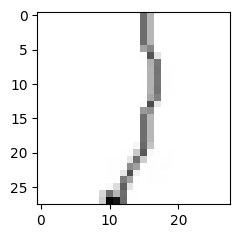

In [87]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

for i, (images, labels) in enumerate(train_loader):
    print("Image size =",images.shape)
    print("Label size =",labels.shape)
    img = images[0]
    plt.figure(figsize=(2.5,2.5))
    plt.imshow(img[0], cmap='gray')
    plt.show()
    break

## Model Architecture

In [88]:
class CharacterNet(Module):

    ''' CNN architecture for character recognition '''

    def __init__(self):

        super(CharacterNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Sequential(
            nn.Linear(64*7*7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 36)
        )

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc(x)
        x = F.softmax(x, dim=1)

        return x

In [89]:
model = CharacterNet()
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable Parameters:", trainable_params)


Trainable Parameters: 3366948


## Without Scheduler

In [96]:
model = CharacterNet().to(device)
num_epochs = 200
optimizer = Adam(model.parameters(), lr =0.001)
criterion = nn.CrossEntropyLoss()
epsilona = 0.3

training_losses = []
val_losses = []
training_accuracies = []
val_accuracies = []

klm = 0
                                                                                  # Training loop with adversarial training
for epoch in range(num_epochs):
    print("Epoch",epoch, end=" ")
    klm+=1
    train_loss, train_acc = adversarial_train(model, data, device, train_loader, optimizer, criterion, epsilona, klm, custom=False)
    val_loss, val_acc = adversarial_validate(model, device, val_loader, criterion)

    training_losses.append(train_loss)
    val_losses.append(val_loss)
    training_accuracies.append(train_acc)
    val_accuracies.append(val_acc)


Epoch 0 Loss: 7.166776418685913 Train accuracy: 0.026394125818614805 Validation Loss: 3.5809570340549244 Validation Accuracy: 0.03518518518518519
Epoch 1 Loss: 7.146548402309418 Train accuracy: 0.03671363365747172 Validation Loss: 3.545340201433967 Validation Accuracy: 0.07592592592592592
Epoch 2 Loss: 7.054327118396759 Train accuracy: 0.03909505854336178 Validation Loss: 3.3860168316785026 Validation Accuracy: 0.2657407407407407
Epoch 3 Loss: 6.886160755157471 Train accuracy: 0.053582059932526294 Validation Loss: 3.31886692608104 Validation Accuracy: 0.325
Epoch 4 Loss: 6.811182129383087 Train accuracy: 0.060130978368723956 Validation Loss: 3.251212891410379 Validation Accuracy: 0.38472222222222224
Epoch 5 Loss: 6.7846564769744875 Train accuracy: 0.058940265925778924 Validation Loss: 3.226097149007461 Validation Accuracy: 0.4060185185185185
Epoch 6 Loss: 6.760842525959015 Train accuracy: 0.05318515578487795 Validation Loss: 3.209257911233341 Validation Accuracy: 0.425462962962963
Epoc

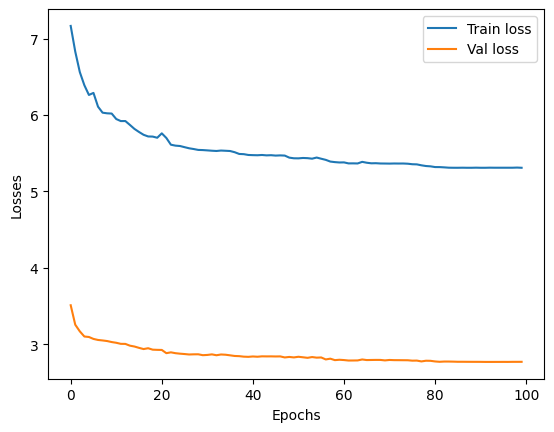

In [21]:
plt.plot(training_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()
plt.show()

In [22]:
#model_path = "UnscheduledCharacterNet_model.pth"
#torch.save(model.state_dict(), model_path)

## With ReduceLROnPlateau Scheduler

In [23]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = CharacterNet().to(device)
num_epochs = 100
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epsilona = 0.3

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [24]:
klm =0
training_losses = []
val_losses = []
training_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print("Epoch", epoch, end=" ")
    klm+=1
    train_loss, train_acc = adversarial_train(model, data, device, train_loader, optimizer, criterion, epsilona, klm, custom=False)
    val_loss, val_acc = adversarial_validate(model, device, val_loader, criterion)

    training_losses.append(train_loss)
    val_losses.append(val_loss)
    training_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step(val_loss)                    

Epoch 0 Loss: 7.174516904354095 Train accuracy: 0.030164715221274063 Validation Loss: 3.5807587819940903 Validation Accuracy: 0.03425925925925926
Epoch 1 Loss: 7.07990928888321 Train accuracy: 0.06211549910696567 Validation Loss: 3.3825842913459327 Validation Accuracy: 0.2513888888888889
Epoch 2 Loss: 6.755313968658447 Train accuracy: 0.1668981940861282 Validation Loss: 3.2556630583370434 Validation Accuracy: 0.38101851851851853
Epoch 3 Loss: 6.524680662155151 Train accuracy: 0.2901369319309387 Validation Loss: 3.1885556613697723 Validation Accuracy: 0.4425925925925926
Epoch 4 Loss: 6.400881886482239 Train accuracy: 0.37884500893034334 Validation Loss: 3.177637619130752 Validation Accuracy: 0.4532407407407407
Epoch 5 Loss: 6.367565250396728 Train accuracy: 0.39154594165509027 Validation Loss: 3.157969390644747 Validation Accuracy: 0.4740740740740741
Epoch 6 Loss: 6.29107813835144 Train accuracy: 0.42925183568168285 Validation Loss: 3.1225804020376766 Validation Accuracy: 0.508333333333

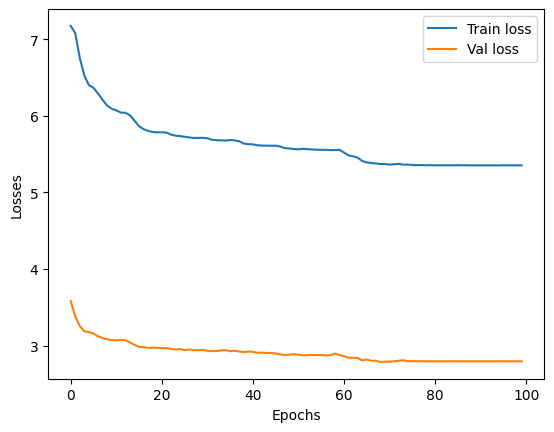

In [25]:
plt.plot(training_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()
plt.show()

In [26]:
model_path = "ScheduledCharacterNet_model.pth"
torch.save(model.state_dict(), model_path)

## With Custom Scheduler

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class CharacterNet(nn.Module):
    ''' CNN architecture for character recognition '''
    def __init__(self):
        super(CharacterNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 36)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 512 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x


In [ ]:
model = CharacterNet().to(device)
num_epochs = 100
optimizer = Adam(model.parameters(), lr =0.01)
criterion = nn.CrossEntropyLoss()
epsilona = 0.3
training_losses = []
val_losses = []
training_accuracies = []
val_accuracies = []

klm = 0
prev_loss = -1                                                                                  # Training loop with adversarial training
for epoch in range(num_epochs):
    print("Epoch",epoch, end=" ")
    klm+=1
    train_loss, train_acc = adversarial_train(model, data, device, train_loader, optimizer, criterion, epsilona, klm, custom=True)
    val_loss, val_acc = adversarial_validate(model, device, val_loader, criterion)
    
    training_losses.append(train_loss)
    val_losses.append(val_loss)
    training_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if(train_acc >= 0.92):
        break

In [ ]:
plt.plot(training_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()
plt.show()

In [ ]:
model_path = "CustomScheduledCharacterNet_model.pth"
torch.save(model.state_dict(), model_path)

## Testing Results on Varying Schedulers

In [ ]:
''' Unscheduled Character Net '''

count = 0
total = 0
base_model = CharacterNet()

base_model.load_state_dict(torch.load('../Handwritten-Equation-Solver/UnscheduledCharacterNet_model.pth'))
base_model.to(device)

with torch.no_grad():
    for images, labels in val_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = base_model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(images)):
            total += 1
            img = images[i].cpu().numpy()
            pred = predicted[i].cpu().item()
            label = labels[i].cpu().item()

            if(label == pred):
                count += 1
        break

print("Accuracy =",count/total)

In [ ]:
''' Scheduled Character Net '''

count = 0
total = 0
model1 = CharacterNet()

model1.load_state_dict(torch.load('../Handwritten-Equation-Solver/ScheduledCharacterNet_model.pth'))
model1.to(device)

with torch.no_grad():
    for images, labels in val_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model1(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(images)):
            total += 1
            img = images[i].cpu().numpy()
            pred = predicted[i].cpu().item()
            label = labels[i].cpu().item()

            if(label == pred):
                count += 1
        break

print("Accuracy =",count/total)

Accuracy = 0.9140625


In [ ]:
''' Custom Scheduled Character Net'''

count = 0
total = 0
model2 = CharacterNet()

model2.load_state_dict(torch.load('../Handwritten-Equation-Solver/CustomScheduledCharacterNet_model.pth'))
model2.to(device)

with torch.no_grad():
    for images, labels in val_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model2(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(images)):
            total += 1
            img = images[i].cpu().numpy()
            pred = predicted[i].cpu().item()
            label = labels[i].cpu().item()

            if(label == pred):
                count += 1
        break

print("Accuracy =",count/total)

Accuracy = 0.8515625


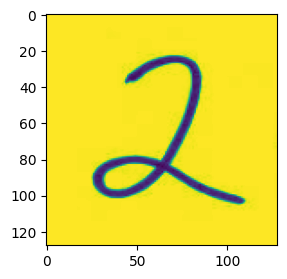

2


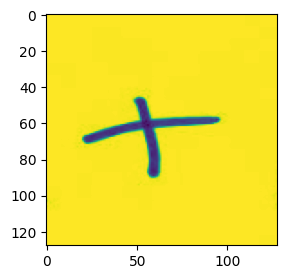

add


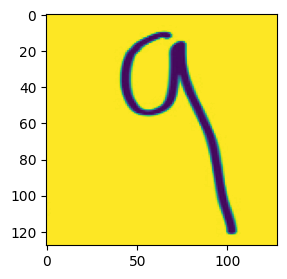

n


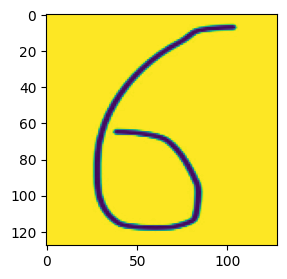

6


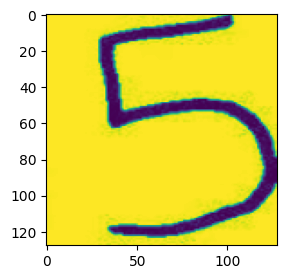

div


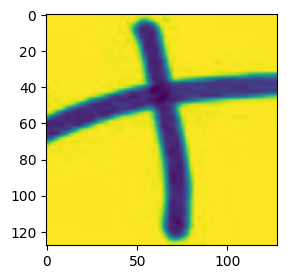

add


In [ ]:
for i in range(5,7):

    ii = cv2.imread('../Handwritten-Equation-Solver/test_data/'+ str(i) + '.jpeg')
    gray_image = cv2.cvtColor(ii, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.resize(gray_image, (28,28))
    gray_image = gray_image.reshape((1,28,28))
    data = torch.Tensor(np.array([gray_image])).to(device)
    output = base_model(data)
    _, predicted = torch.max(output.data, 1)
    plt.figure(figsize=(3,3))
    plt.imshow(gray_image[0])
    plt.show()
    print(mapping[predicted.cpu().numpy()[0]])

for i in range(7,9):

    ii = cv2.imread('../Handwritten-Equation-Solver/test_data/'+ str(i) + '.png')
    gray_image = cv2.cvtColor(ii, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.resize(gray_image, (28,28))
    gray_image = gray_image.reshape((1,28,28))
    data = torch.Tensor(np.array([gray_image])).to(device)
    output = base_model(data)
    _, predicted = torch.max(output.data, 1)
    plt.figure(figsize=(3,3))
    plt.imshow(gray_image[0])
    plt.show()
    print(mapping[predicted.cpu().numpy()[0]])

for i in range(9,11):

    ii = cv2.imread('../Handwritten-Equation-Solver/test_data/'+ str(i) + '.jpeg')
    gray_image = cv2.cvtColor(ii, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.resize(gray_image, (28,28))
    gray_image = gray_image.reshape((1,28,28))
    data = torch.Tensor(np.array([gray_image])).to(device)
    output = base_model(data)
    _, predicted = torch.max(output.data, 1)
    plt.figure(figsize=(3,3))
    plt.imshow(gray_image[0])
    plt.show()
    print(mapping[predicted.cpu().numpy()[0]])

In [ ]:
torch.save(model.state_dict(), 'AdversarialCharacterNet.pth')